In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import plotly

from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from itertools import product

# Set random seed for reproducibility
torch.manual_seed(0)

# Torch version
torch.__version__

'2.4.1+cu124'

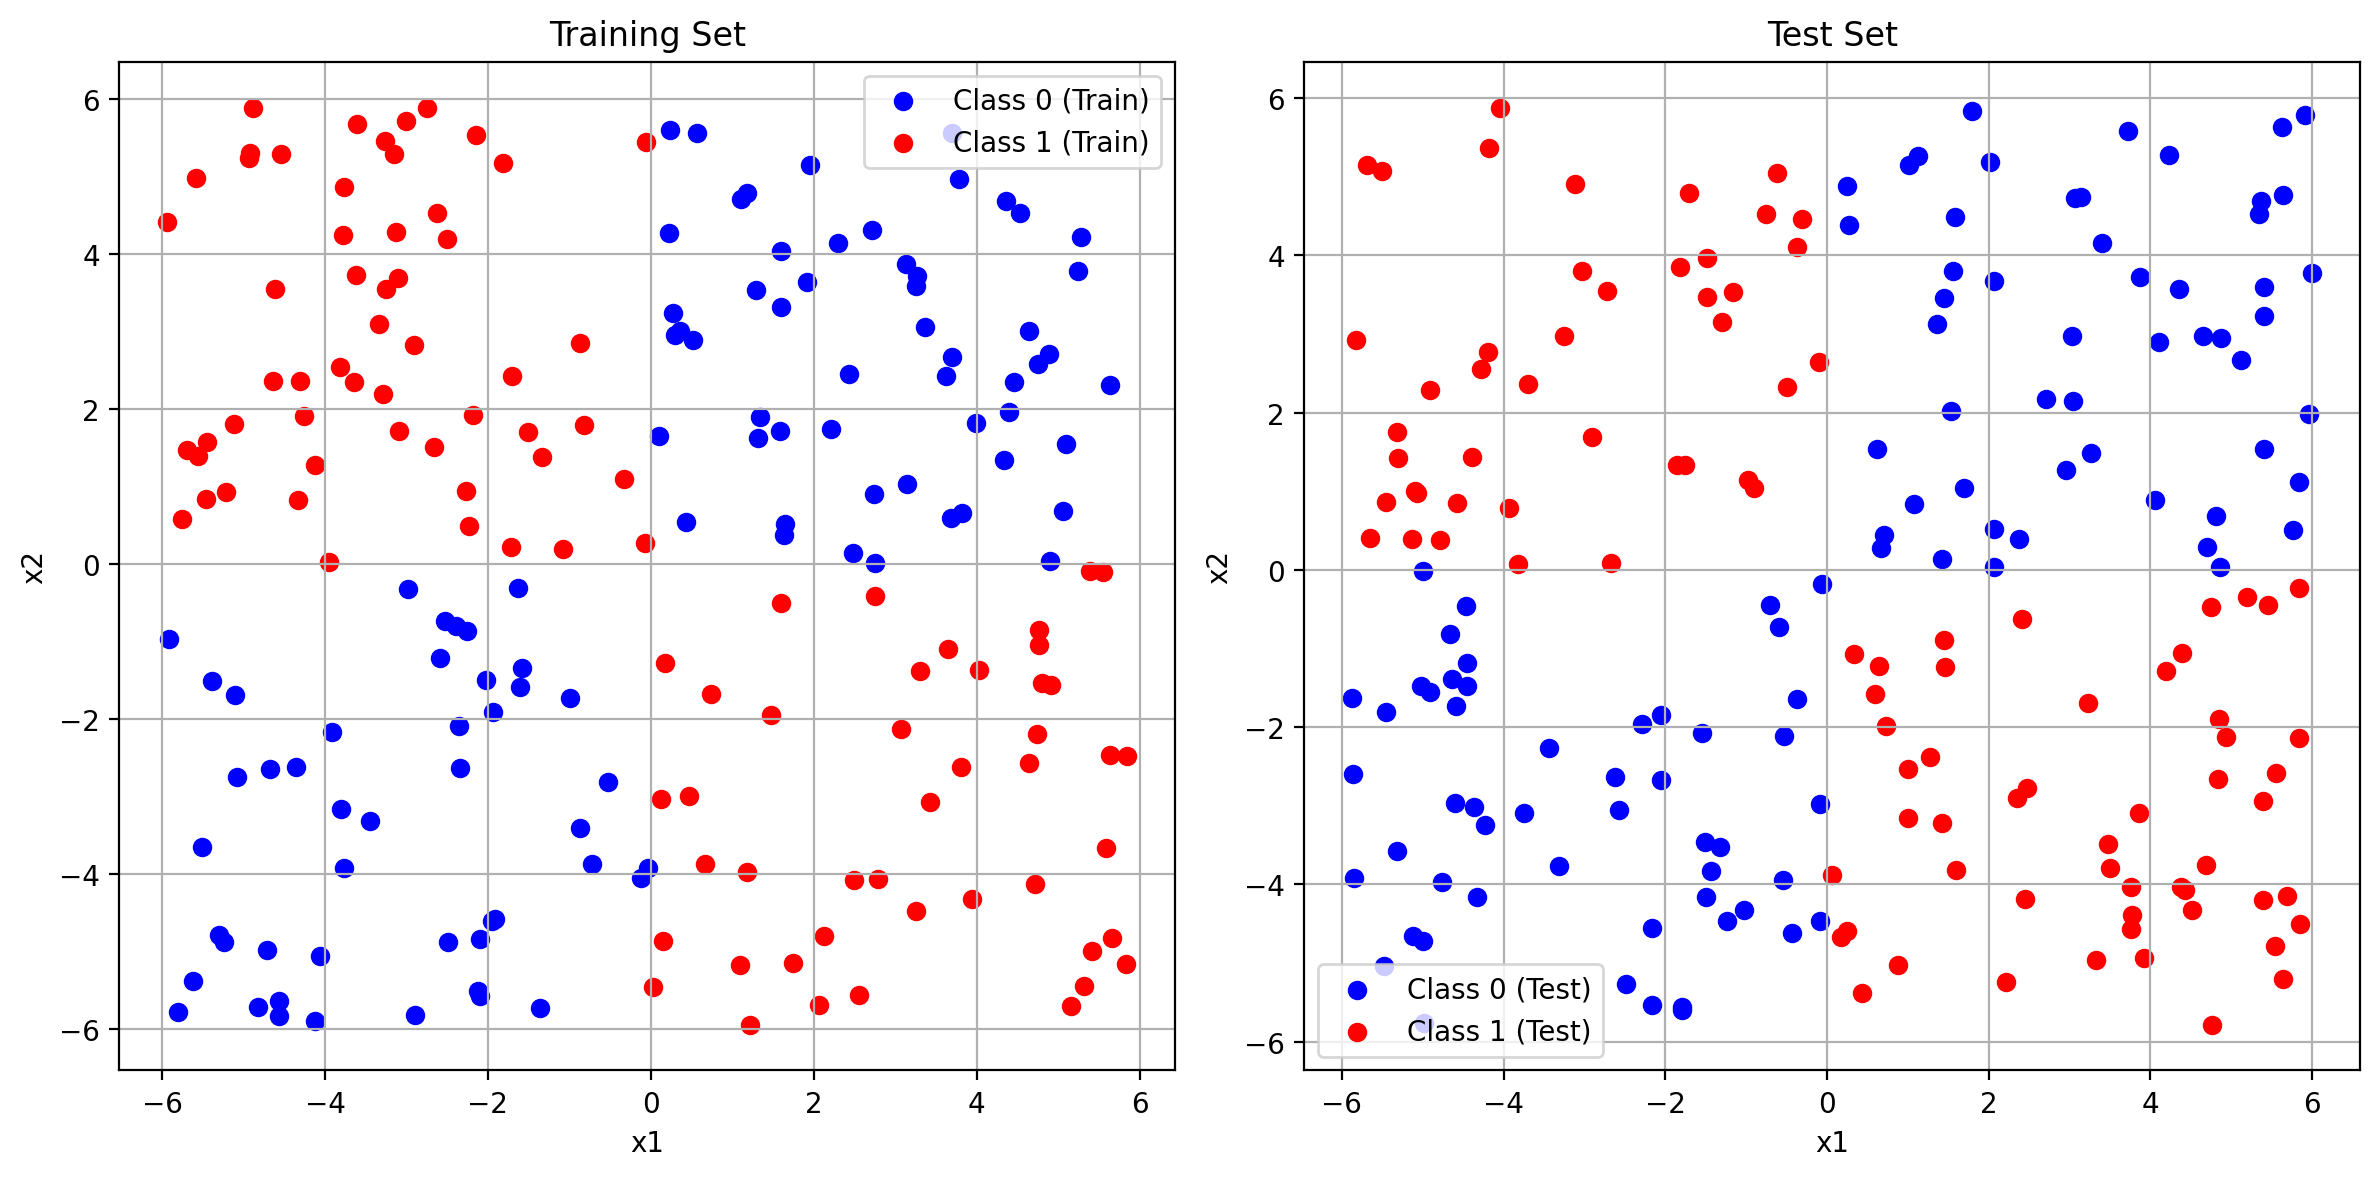

In [40]:
np.random.seed(42)

num_train_samples = 200
num_test_samples = 200

# Training set
x1_train = np.random.uniform(-6, 6, num_train_samples)
x2_train = np.random.uniform(-6, 6, num_train_samples)
x1_train_reshaped = x1_train.reshape(-1, 1) # Reshaping to a column vector
x2_train_reshaped = x2_train.reshape(-1, 1) # Reshape to a column vector
concatenated_x_train = np.concatenate((x1_train_reshaped,x2_train_reshaped), axis=1)
y_train = np.logical_xor(x1_train > 0, x2_train > 0).astype(int) # Labels according to XOR function

# Test set
x1_test = np.random.uniform(-6, 6, num_test_samples)
x2_test = np.random.uniform(-6, 6, num_test_samples)
x1_test_reshaped = x1_test.reshape(-1, 1) 
x2_test_reshaped = x2_test.reshape(-1, 1) 
concatenated_x_test = np.concatenate((x1_test_reshaped,x2_test_reshaped), axis=1)
y_test = np.logical_xor(x1_test > 0, x2_test > 0).astype(int)
# Plot the data
plt.figure(figsize=(12, 6))

# Training set
plt.subplot(1, 2, 1)
plt.scatter(x1_train[y_train==0], x2_train[y_train==0], c='b', label='Class 0 (Train)')
plt.scatter(x1_train[y_train==1], x2_train[y_train==1], c='r', label='Class 1 (Train)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Training Set')
plt.legend()
plt.grid(True)

# Test set
plt.subplot(1, 2, 2)
plt.scatter(x1_test[y_test==0], x2_test[y_test==0], c='b', label='Class 0 (Test)')
plt.scatter(x1_test[y_test==1], x2_test[y_test==1], c='r', label='Class 1 (Test)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Test Set')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [41]:
targets_train = torch.tensor(y_train, dtype=torch.float32)
targets_train = targets_train.reshape(-1, 1)

targets_test = torch.tensor(y_test, dtype=torch.float32)
targets_test = targets_test.reshape(-1, 1)

In [42]:
torch.manual_seed(42)
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x    
    
    

# a

In [43]:
def train_model(model, criterion, optimizer, x_train, y_train, num_epochs, batch_size):           
    for epoch in range(num_epochs):
        for i in range(0, x_train.shape[0], batch_size):
            x = torch.tensor(x_train, dtype=torch.float32)[i:i+batch_size]
            y = y_train[i:i+batch_size]
            
            outputs = model.forward(x)

            loss = criterion(outputs,y)

            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
            
    return model

In [44]:
def accuracy(predicted,true_labels):
    result = torch.where(predicted > 0, torch.tensor(1), torch.tensor(0))
    accuracy = (result == true_labels).sum().item() / len(true_labels)
    return accuracy

In [46]:
torch.manual_seed(1)
model_to_learn_no_reg = MLP(2,4,1)
learned_model_no_reg = train_model(model_to_learn_no_reg, nn.BCEWithLogitsLoss(), optim.SGD(model_to_learn_no_reg.parameters(), lr=0.1), concatenated_x_train, targets_train, 1000, 10)
a1 = accuracy(learned_model_no_reg.forward(torch.tensor(concatenated_x_test, dtype=torch.float32)), targets_test)
print(f'Accuracy on the testing set: {a1*100:.2f} %')

Epoch 0, Loss: 0.7036072015762329
Epoch 100, Loss: 0.004863427486270666
Epoch 200, Loss: 0.0025894378777593374
Epoch 300, Loss: 0.0015530871460214257
Epoch 400, Loss: 0.0012337910011410713
Epoch 500, Loss: 0.0010261894203722477
Epoch 600, Loss: 0.0007070324500091374
Epoch 700, Loss: 0.000537283078301698
Epoch 800, Loss: 0.00044234361848793924
Epoch 900, Loss: 0.0003803168947342783
Accuracy on the testing set: 99.00 %


In [89]:
# plot the decision surface for the obtained model.

def predict_plot_grid(model,s):
    x1 = np.linspace(-6, 6, s)
    x2 = np.linspace(-6, 6, s)
    xx1, xx2 = np.meshgrid(x1, x2)
    X = np.column_stack((xx1.ravel(), xx2.ravel()))
    y = model.forward(torch.tensor(X, dtype=torch.float32)).detach().numpy().reshape(s, s)
    return xx1, xx2, y
# plot the decision surface for the obtained model.

def plot_decision_surface(model, x_train, y_train, x_test, y_test, s=100):
    print(predict_plot_grid(model,s))
    xx1, xx2, y = predict_plot_grid(model,s)
    plt.figure(figsize=(12, 6))

    # Training set
    plt.subplot(1, 2, 1)
    plt.contourf(xx1, xx2, y, alpha=0.5)
    plt.scatter(x_train[y_train==0][:,0], x_train[y_train==0][:,1], c='b', label='Class 0 (Train)')
    plt.scatter(x_train[y_train==1][:,0], x_train[y_train==1][:,1], c='r', label='Class 1 (Train)')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Training Set')
    plt.legend()
    plt.grid(True)

    # Test set
    plt.subplot(1, 2, 2)
    plt.contourf(xx1, xx2, y, alpha=0.5)
    plt.scatter(x_test[y_test==0][:,0], x_test[y_test==0][:,1], c='b', label='Class 0 (Test)')
    plt.scatter(x_test[y_test==1][:,0], x_test[y_test==1][:,1], c='r', label='Class 1 (Test)')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Test Set')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

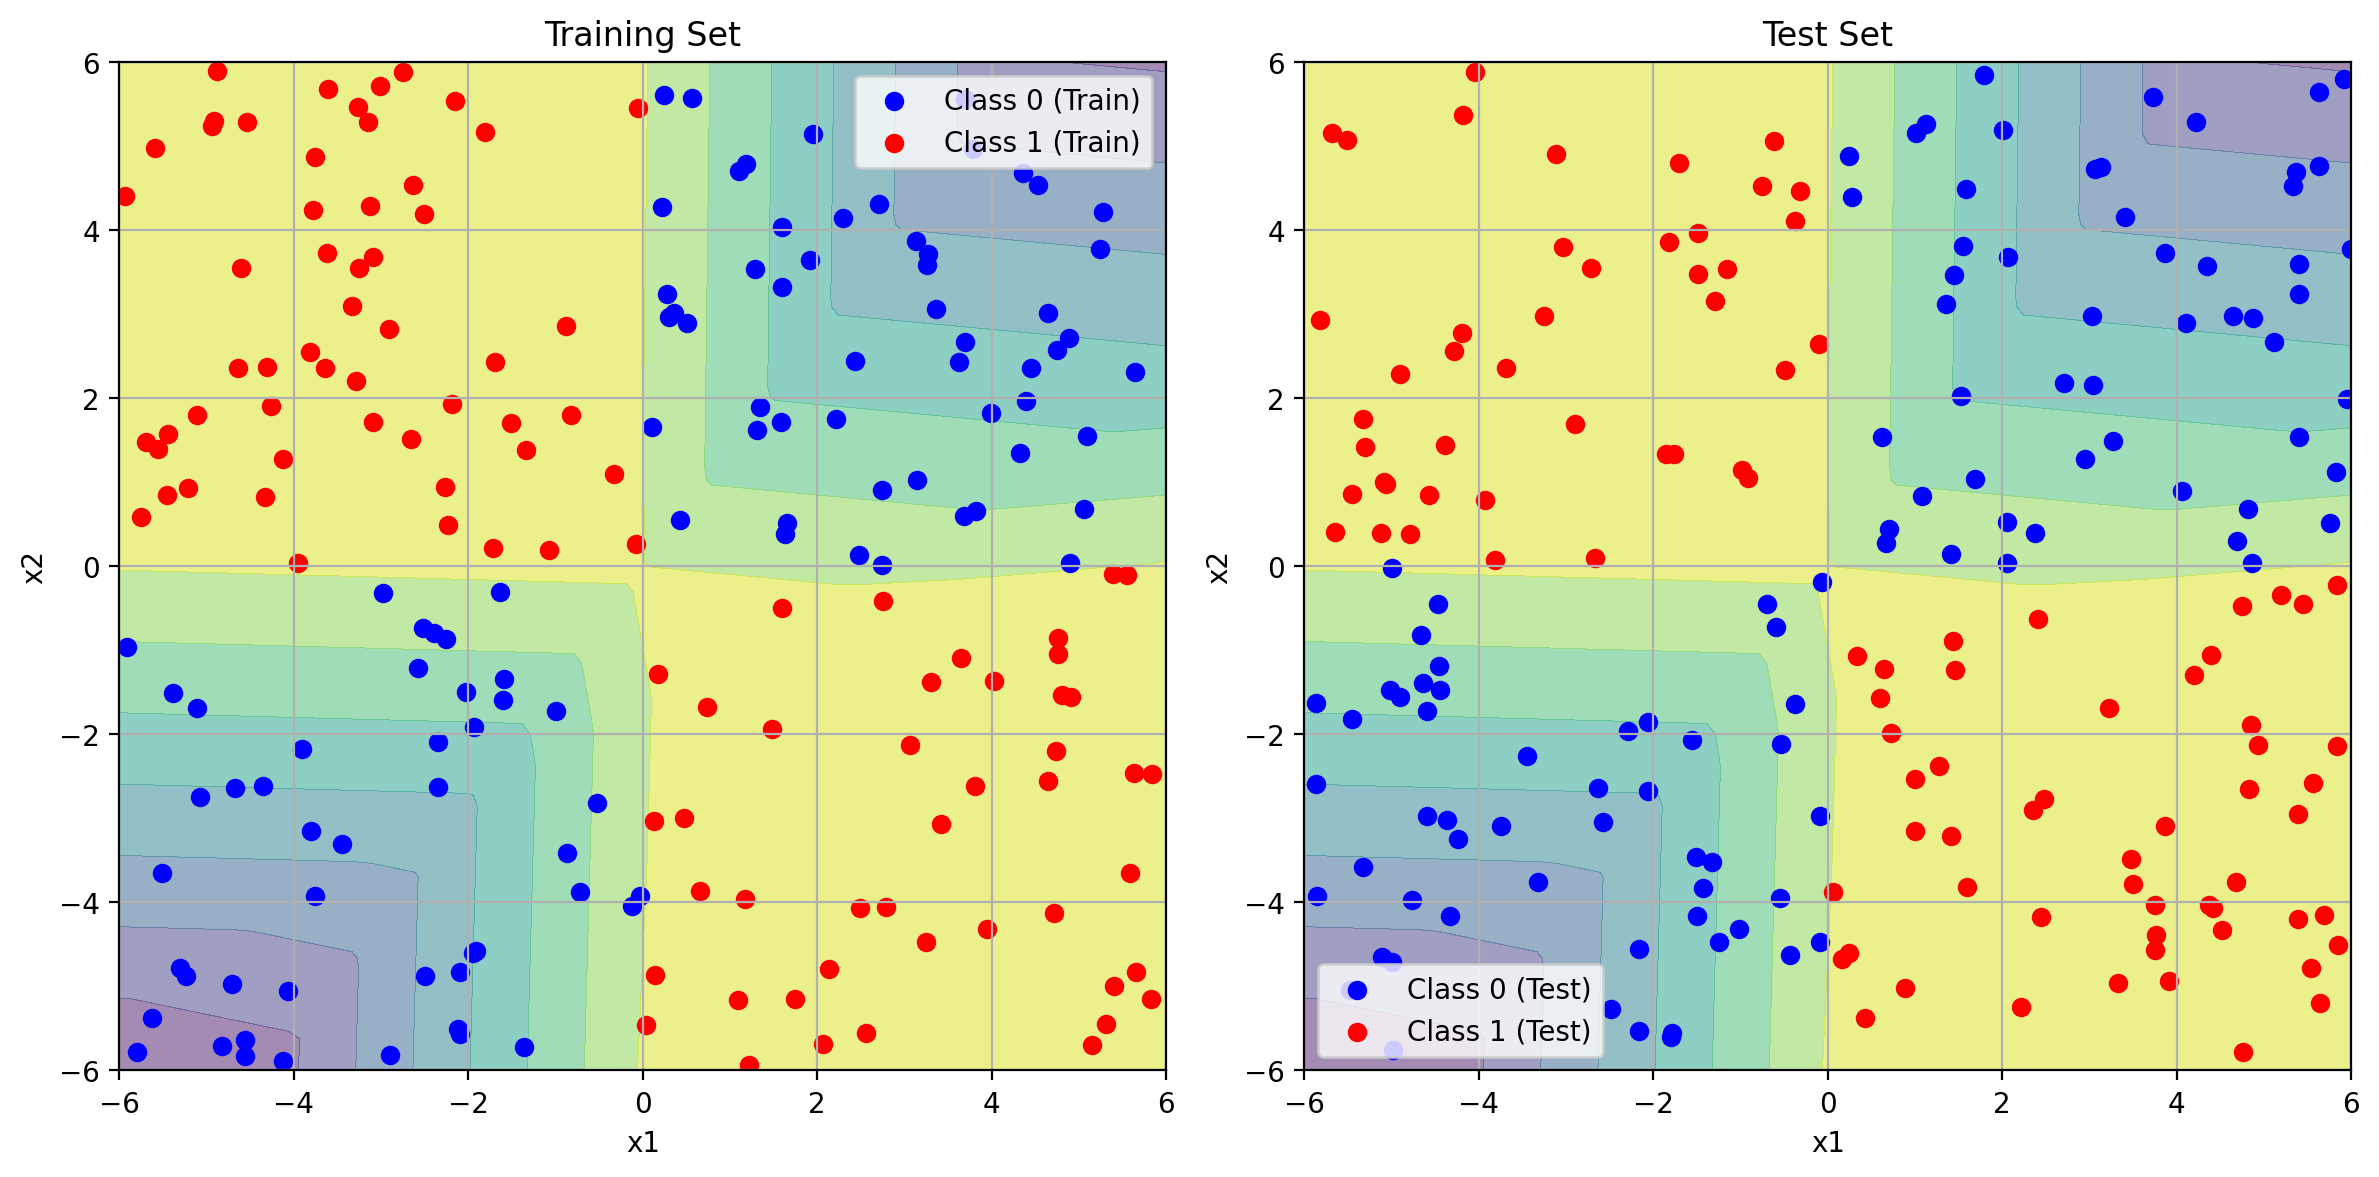

In [85]:
plot_decision_surface(learned_model_no_reg, concatenated_x_train, y_train, concatenated_x_test, y_test, s=100)

# b 

In [51]:
def train_model_with_l1_reg(model, criterion, optimizer, x_train, y_train, num_epochs, batch_size, regularisation_coeff):
    for epoch in range(num_epochs):
        for i in range(0, x_train.shape[0], batch_size):
            x = torch.tensor(x_train, dtype=torch.float32)[i:i+batch_size]
            y = y_train[i:i+batch_size]
            outputs = model.forward(x)

            loss = criterion(outputs,y)
            l1_regularization = torch.tensor(0.)
            for param in model.parameters():
                l1_regularization += torch.norm(param, p=1)
            loss += regularisation_coeff * l1_regularization

            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
            
    return model

In [52]:
def accuracy(predicted,true_labels):
    result = torch.where(predicted > 0, torch.tensor(1), torch.tensor(0))
    accuracy = (result == true_labels).sum().item() / len(true_labels)
    return accuracy

In [54]:
torch.manual_seed(1)
model_to_learn_l1 = MLP(2,4,1)
learned_model_l1 = train_model_with_l1_reg(model_to_learn_l1, nn.BCEWithLogitsLoss(), optim.SGD(model_to_learn_l1.parameters(), lr=0.01), concatenated_x_train, targets_train, 1000, 20, 0.001)
a2 = accuracy(learned_model_l1.forward(torch.tensor(concatenated_x_test, dtype=torch.float32)), targets_test)
print(f'Accuracy on the testing set: {a2*100:.2f} %')

Epoch 0, Loss: 0.8491241931915283
Epoch 100, Loss: 0.48550406098365784
Epoch 200, Loss: 0.15237091481685638
Epoch 300, Loss: 0.09395831823348999
Epoch 400, Loss: 0.072307288646698
Epoch 500, Loss: 0.06161452829837799
Epoch 600, Loss: 0.05523955821990967
Epoch 700, Loss: 0.051115281879901886
Epoch 800, Loss: 0.04828962683677673
Epoch 900, Loss: 0.04628869891166687
Accuracy on the testing set: 99.50 %


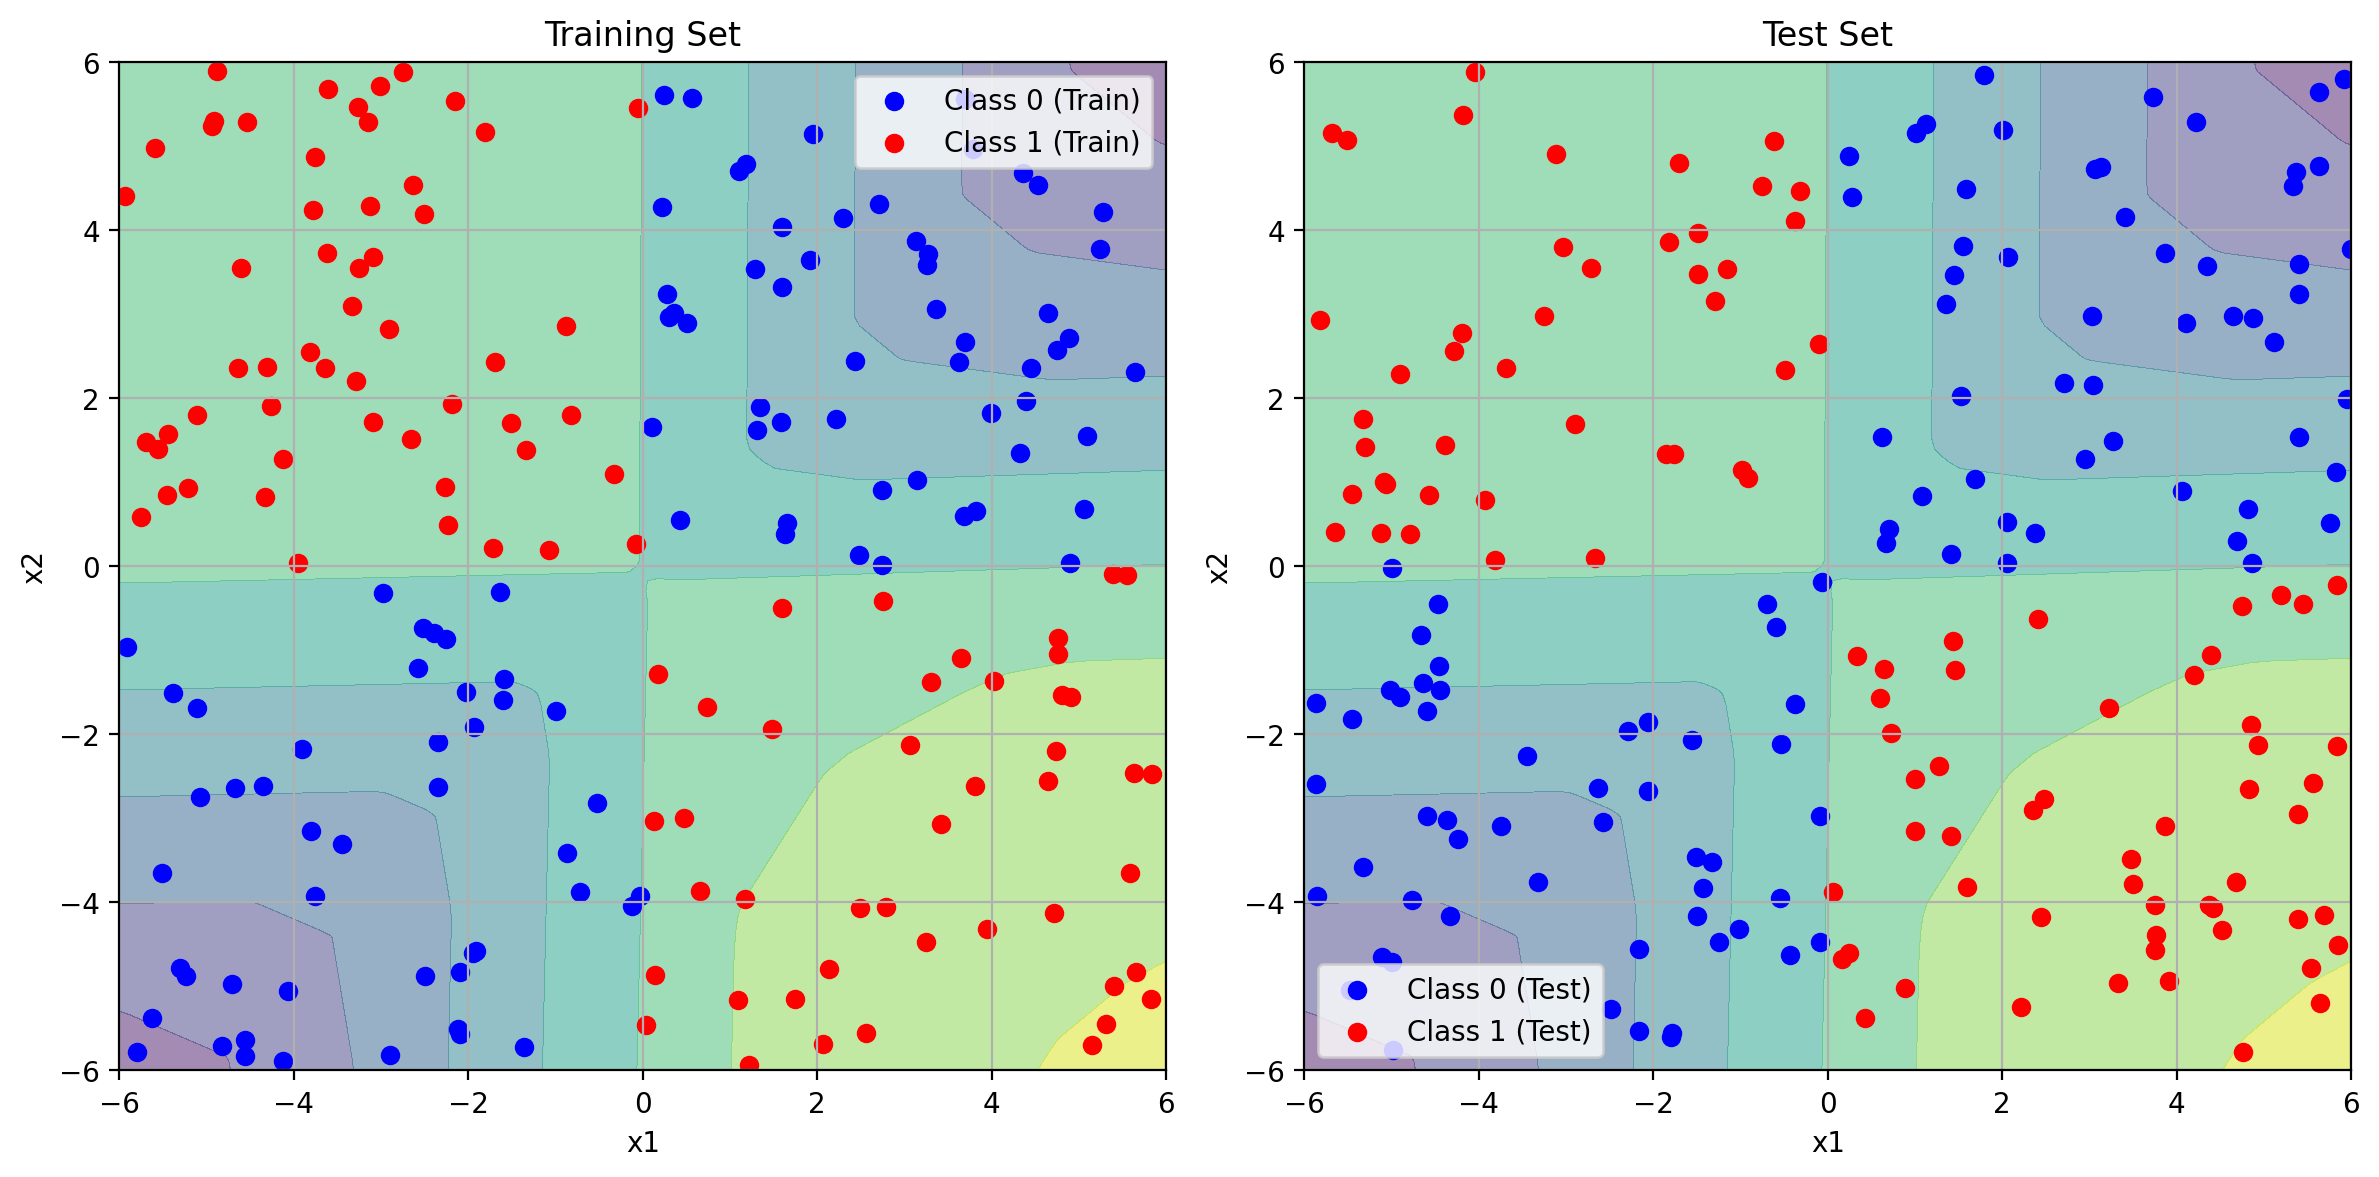

In [60]:
plot_decision_surface(learned_model_l1, concatenated_x_train, y_train, concatenated_x_test, y_test, s=100)

# c

In [56]:
def train_model_with_l2_reg(model, criterion, optimizer, x_train, y_train, num_epochs, batch_size, regularisation_coeff):
    for epoch in range(num_epochs):
        for i in range(0, x_train.shape[0], batch_size):
            x = torch.tensor(x_train, dtype=torch.float32)[i:i+batch_size]
            y = y_train[i:i+batch_size]
            outputs = model.forward(x)

            loss = criterion(outputs,y)
            l2_regularization = torch.tensor(0.)
            for param in model.parameters():
                l2_regularization += torch.norm(param, p=2)
            loss += regularisation_coeff * l2_regularization

            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
            
    return model

In [57]:
def accuracy(predicted,true_labels):
    result = torch.where(predicted > 0, torch.tensor(1), torch.tensor(0))
    accuracy = (result == true_labels).sum().item() / len(true_labels)
    return accuracy

In [58]:
torch.manual_seed(1)
model_to_learn_l2 = MLP(2,4,1)
learned_model_l2 = train_model_with_l2_reg(model_to_learn_l2, nn.BCEWithLogitsLoss(), optim.SGD(model_to_learn_l2.parameters(), lr=0.01), concatenated_x_train, targets_train, 1000, 20, 0.01)
a3 = accuracy(learned_model_l2.forward(torch.tensor(concatenated_x_test, dtype=torch.float32)), targets_test)
print(f'Accuracy on the testing set: {a3*100:.2f} %')

Epoch 0, Loss: 0.8799701929092407
Epoch 100, Loss: 0.5537825226783752
Epoch 200, Loss: 0.24082395434379578
Epoch 300, Loss: 0.1742277890443802
Epoch 400, Loss: 0.15405093133449554
Epoch 500, Loss: 0.1458013951778412
Epoch 600, Loss: 0.1421385407447815
Epoch 700, Loss: 0.14043331146240234
Epoch 800, Loss: 0.13968269526958466
Epoch 900, Loss: 0.13941489160060883
Accuracy on the testing set: 99.00 %


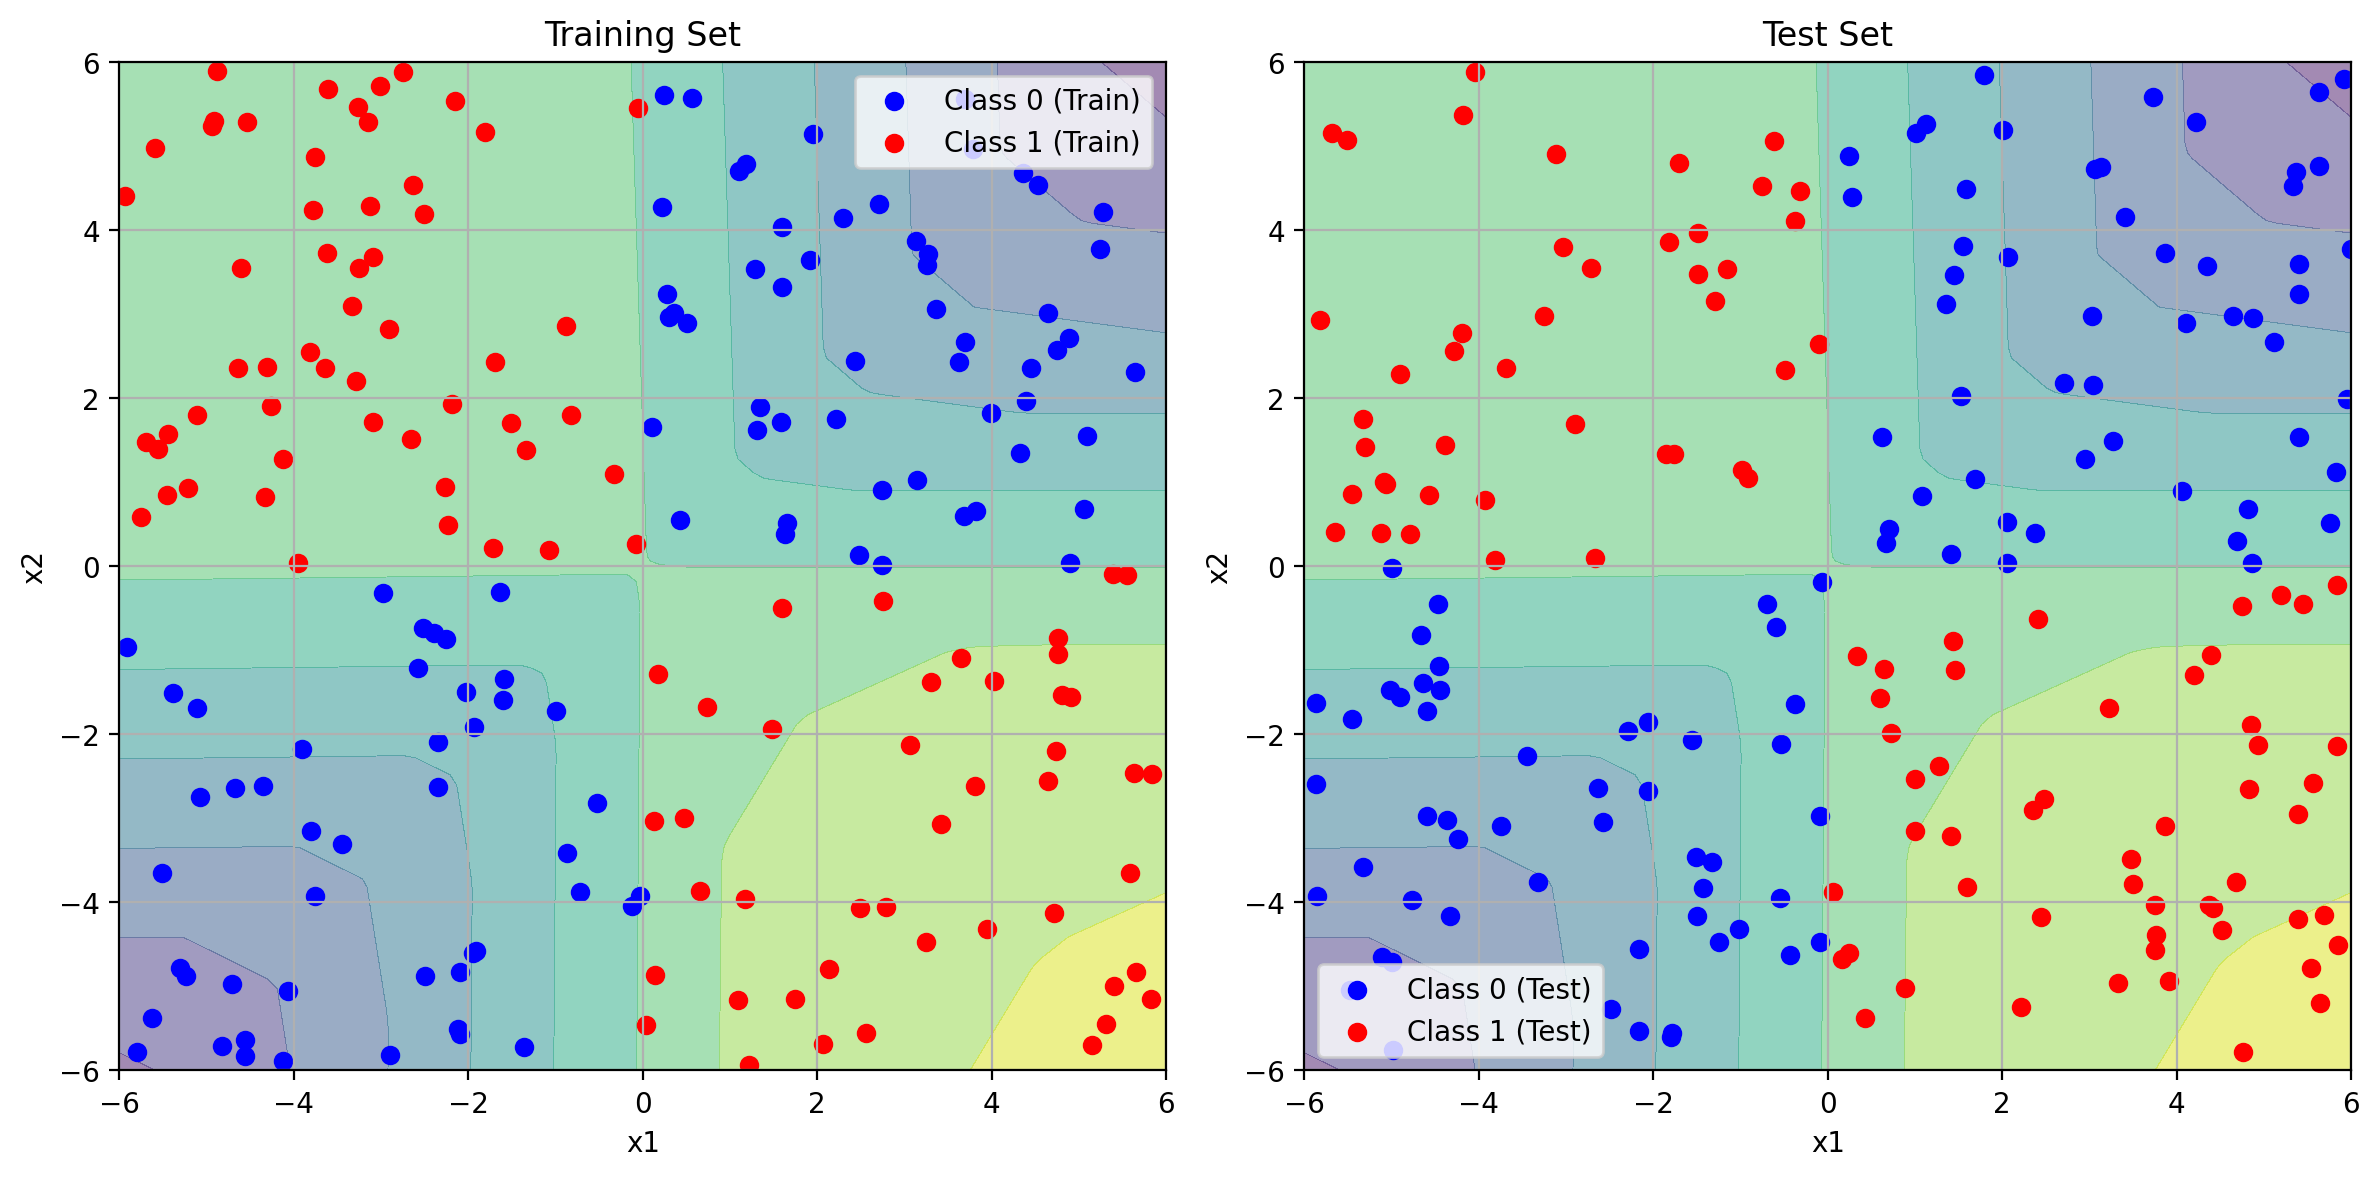

In [59]:
plot_decision_surface(learned_model_l2, concatenated_x_train, y_train, concatenated_x_test, y_test, s=100)

# d

In [31]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        logits = self.linear(x)
        return logits

In [69]:
# Using only x1 and x2 as features
model1 = LogisticRegression(2)
opt1 = torch.optim.Adam(model1.parameters(), lr=0.01)

converged = False
prev_loss = 1e8 
i = 0
while not converged:
    opt1.zero_grad()
    logits = model1(torch.tensor(concatenated_x_train, dtype=torch.float32))
    loss = nn.BCEWithLogitsLoss()(logits, targets_train)
    loss.backward()
    opt1.step()
    if i%10==0:
        print(i, loss.item())
    if np.abs(prev_loss - loss.item()) < 1e-5:
        converged = True
    prev_loss = loss.item() 
    i = i + 1

0 1.1070669889450073
10 0.944599986076355
20 0.8152940273284912
30 0.7328343391418457
40 0.6974550485610962
50 0.6902729868888855
60 0.6907497644424438


In [72]:
prediction_train = model1(torch.tensor(concatenated_x_train, dtype=torch.float32))
prediction_test = model1(torch.tensor(concatenated_x_test, dtype=torch.float32))
probs_train = torch.sigmoid(prediction_train)
print(probs_train.max(), probs_train.min())
probs_test = torch.sigmoid(prediction_test)
y_pred_train = (probs_train > 0.5).float()
y_pred_test = (probs_test > 0.5).float()
train_accuracy = (y_pred_train == targets_train).sum().item() / len(targets_test)
test_accuracy = (y_pred_test == targets_test).sum().item() / len(targets_test)
print(f'Train accuracy: {train_accuracy:.2f}, Test accuracy: {test_accuracy:.2f}')

tensor(0.6102, grad_fn=<MaxBackward1>) tensor(0.3687, grad_fn=<MinBackward1>)
Train accuracy: 0.57, Test accuracy: 0.55


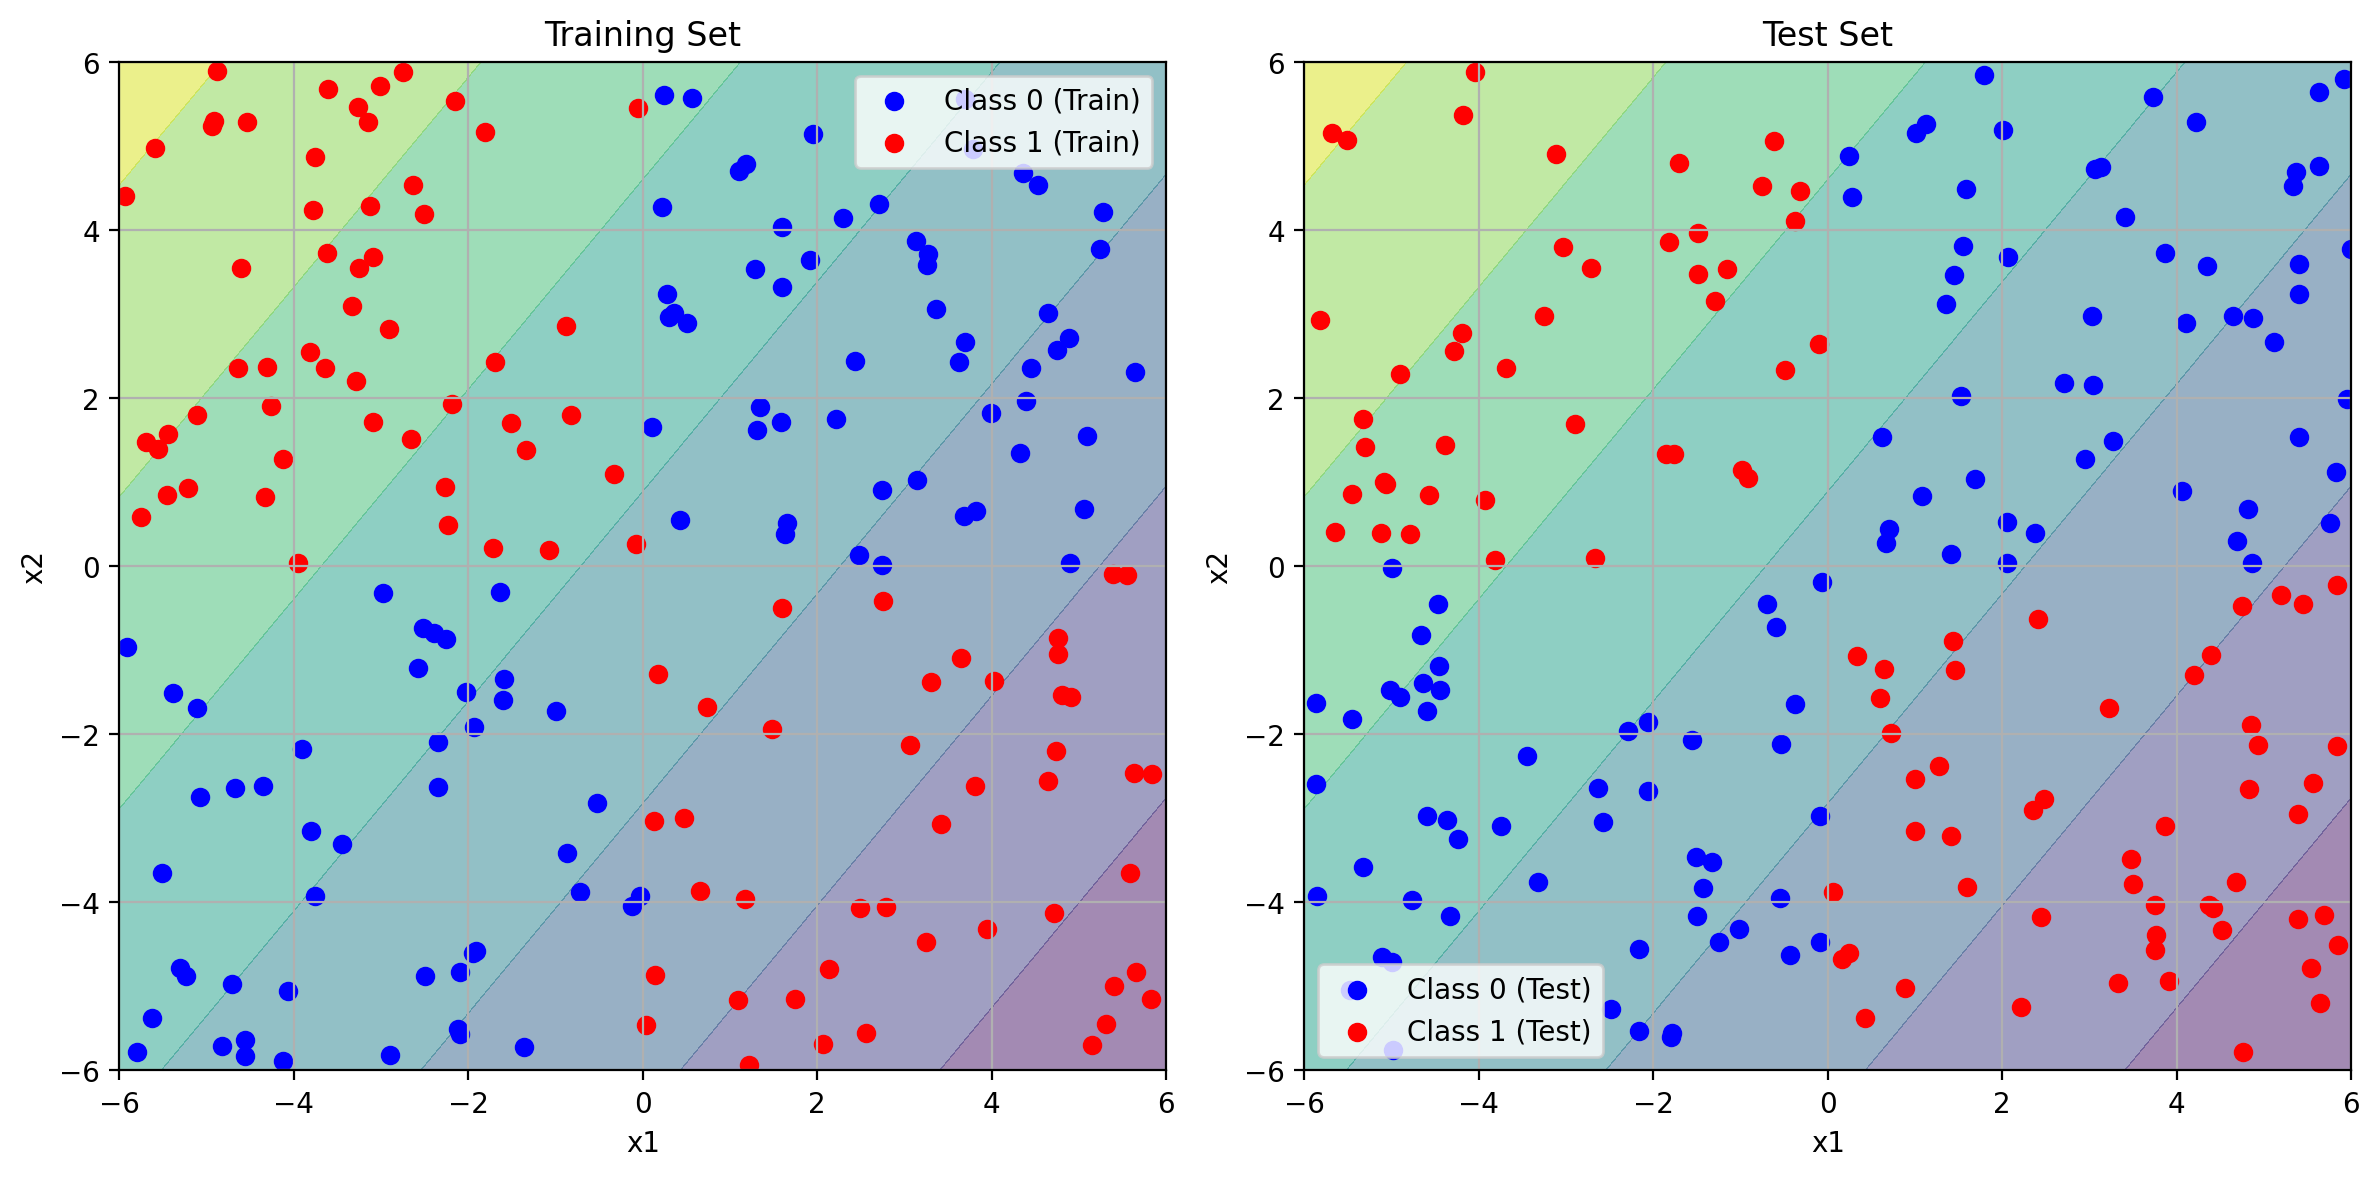

In [87]:
plot_decision_surface(model1, concatenated_x_train, y_train, concatenated_x_test, y_test, s=100)

In [73]:
# Using x1, x2, x1**2 and x2**2 as features

x1 = concatenated_x_train[:, 0] 
x2 = concatenated_x_train[:, 1] 

x1_sq = x1**2
x2_sq = x2**2

x_with_squares = np.concatenate((concatenated_x_train, np.expand_dims(x1_sq, axis=1)), axis=1)
x_with_squares = np.concatenate((x_with_squares, np.expand_dims(x2_sq, axis=1)), axis=1)

model2 = LogisticRegression(4)
opt2 = torch.optim.Adam(model2.parameters(), lr=0.01)

converged = False
prev_loss = 1e8 
i = 0
while not converged:
    opt2.zero_grad()
    logits = model2(torch.tensor(x_with_squares, dtype=torch.float32))
    loss = nn.BCEWithLogitsLoss()(logits, targets_train)
    loss.backward()
    opt2.step()
    if i%10==0:
        print(i, loss.item())
    if np.abs(prev_loss - loss.item()) < 1e-5:
        converged = True
    prev_loss = loss.item() 
    i += 1

0 4.642820358276367
10 3.3073151111602783
20 2.076045036315918
30 1.3000982999801636
40 1.05376398563385
50 0.8691139817237854
60 0.7314103841781616
70 0.7164487242698669
80 0.7123037576675415
90 0.7094029188156128
100 0.7061148285865784
110 0.7043773531913757
120 0.702802836894989
130 0.701346218585968
140 0.699964165687561
150 0.6986331939697266
160 0.6973715424537659
170 0.6961716413497925
180 0.6950350999832153
190 0.6939643621444702
200 0.6929590106010437
210 0.6920187473297119
220 0.6911427974700928
230 0.6903297305107117
240 0.6895773410797119
250 0.6888837218284607
260 0.6882463097572327
270 0.6876623034477234
280 0.6871289610862732
290 0.6866433024406433
300 0.6862024068832397
310 0.685803234577179
320 0.6854428648948669
330 0.6851184368133545
340 0.6848272681236267
350 0.6845664978027344
360 0.6843335628509521
370 0.6841262578964233
380 0.6839420199394226
390 0.6837787628173828
400 0.683634340763092
410 0.6835071444511414
420 0.6833952069282532


In [74]:
x11 = concatenated_x_test[:, 0]
x12 = concatenated_x_test[:, 1]
x_test_with_squares = np.concatenate((concatenated_x_test, np.expand_dims(x11**2, axis=1)), axis=1)
x_test_with_squares = np.concatenate((x_test_with_squares, np.expand_dims(x12**2, axis=1)), axis=1)

prediction_train = model2(torch.tensor(x_with_squares, dtype=torch.float32))
prediction_test = model2(torch.tensor(x_test_with_squares, dtype=torch.float32))
probs_train = torch.sigmoid(prediction_train)
probs_test = torch.sigmoid(prediction_test)
y_pred_train = (probs_train > 0.5).float()
y_pred_test = (probs_test > 0.5).float()
train_accuracy = (y_pred_train == targets_train).sum().item() / len(targets_test)
test_accuracy = (y_pred_test == targets_test).sum().item() / len(targets_test)
print(f'Train accuracy: {train_accuracy:.2f}, Test accuracy: {test_accuracy:.2f}')

Train accuracy: 0.58, Test accuracy: 0.49


In [98]:
def predict_plot_grid_square_features(model):
    x1 = np.linspace(-6, 6, 100)
    x2 = np.linspace(-6, 6, 100)
    xx1, xx2 = np.meshgrid(x1, x2)
    X = np.column_stack((xx1.ravel(), xx2.ravel()))
    X_sq = np.column_stack((X, X[:,0]**2, X[:,1]**2))
    y = model(torch.tensor(X_sq, dtype=torch.float32)).detach().numpy().reshape(100, 100)
    return xx1, xx2, y

def plot_decision_surface(model, x_train, y_train, x_test, y_test, s=100):
    xx1, xx2, y = predict_plot_grid_square_features(model2)
    plt.figure(figsize=(12, 6))

    # Training set
    plt.subplot(1, 2, 1)
    plt.contourf(xx1, xx2, y, alpha=0.5)
    plt.scatter(concatenated_x_train[y_train==0][:,0], concatenated_x_train[y_train==0][:,1], c='b', label='Class 0 (Train)')
    plt.scatter(concatenated_x_train[y_train==1][:,0], concatenated_x_train[y_train==1][:,1], c='r', label='Class 1 (Train)')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Training Set')
    plt.legend()
    plt.grid(True)

    # Test set
    plt.subplot(1, 2, 2)
    plt.contourf(xx1, xx2, y, alpha=0.5)
    plt.scatter(concatenated_x_test[y_test==0][:,0], concatenated_x_test[y_test==0][:,1], c='b', label='Class 0 (Test)')
    plt.scatter(concatenated_x_test[y_test==1][:,0], concatenated_x_test[y_test==1][:,1], c='r', label='Class 1 (Test)')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Test Set')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

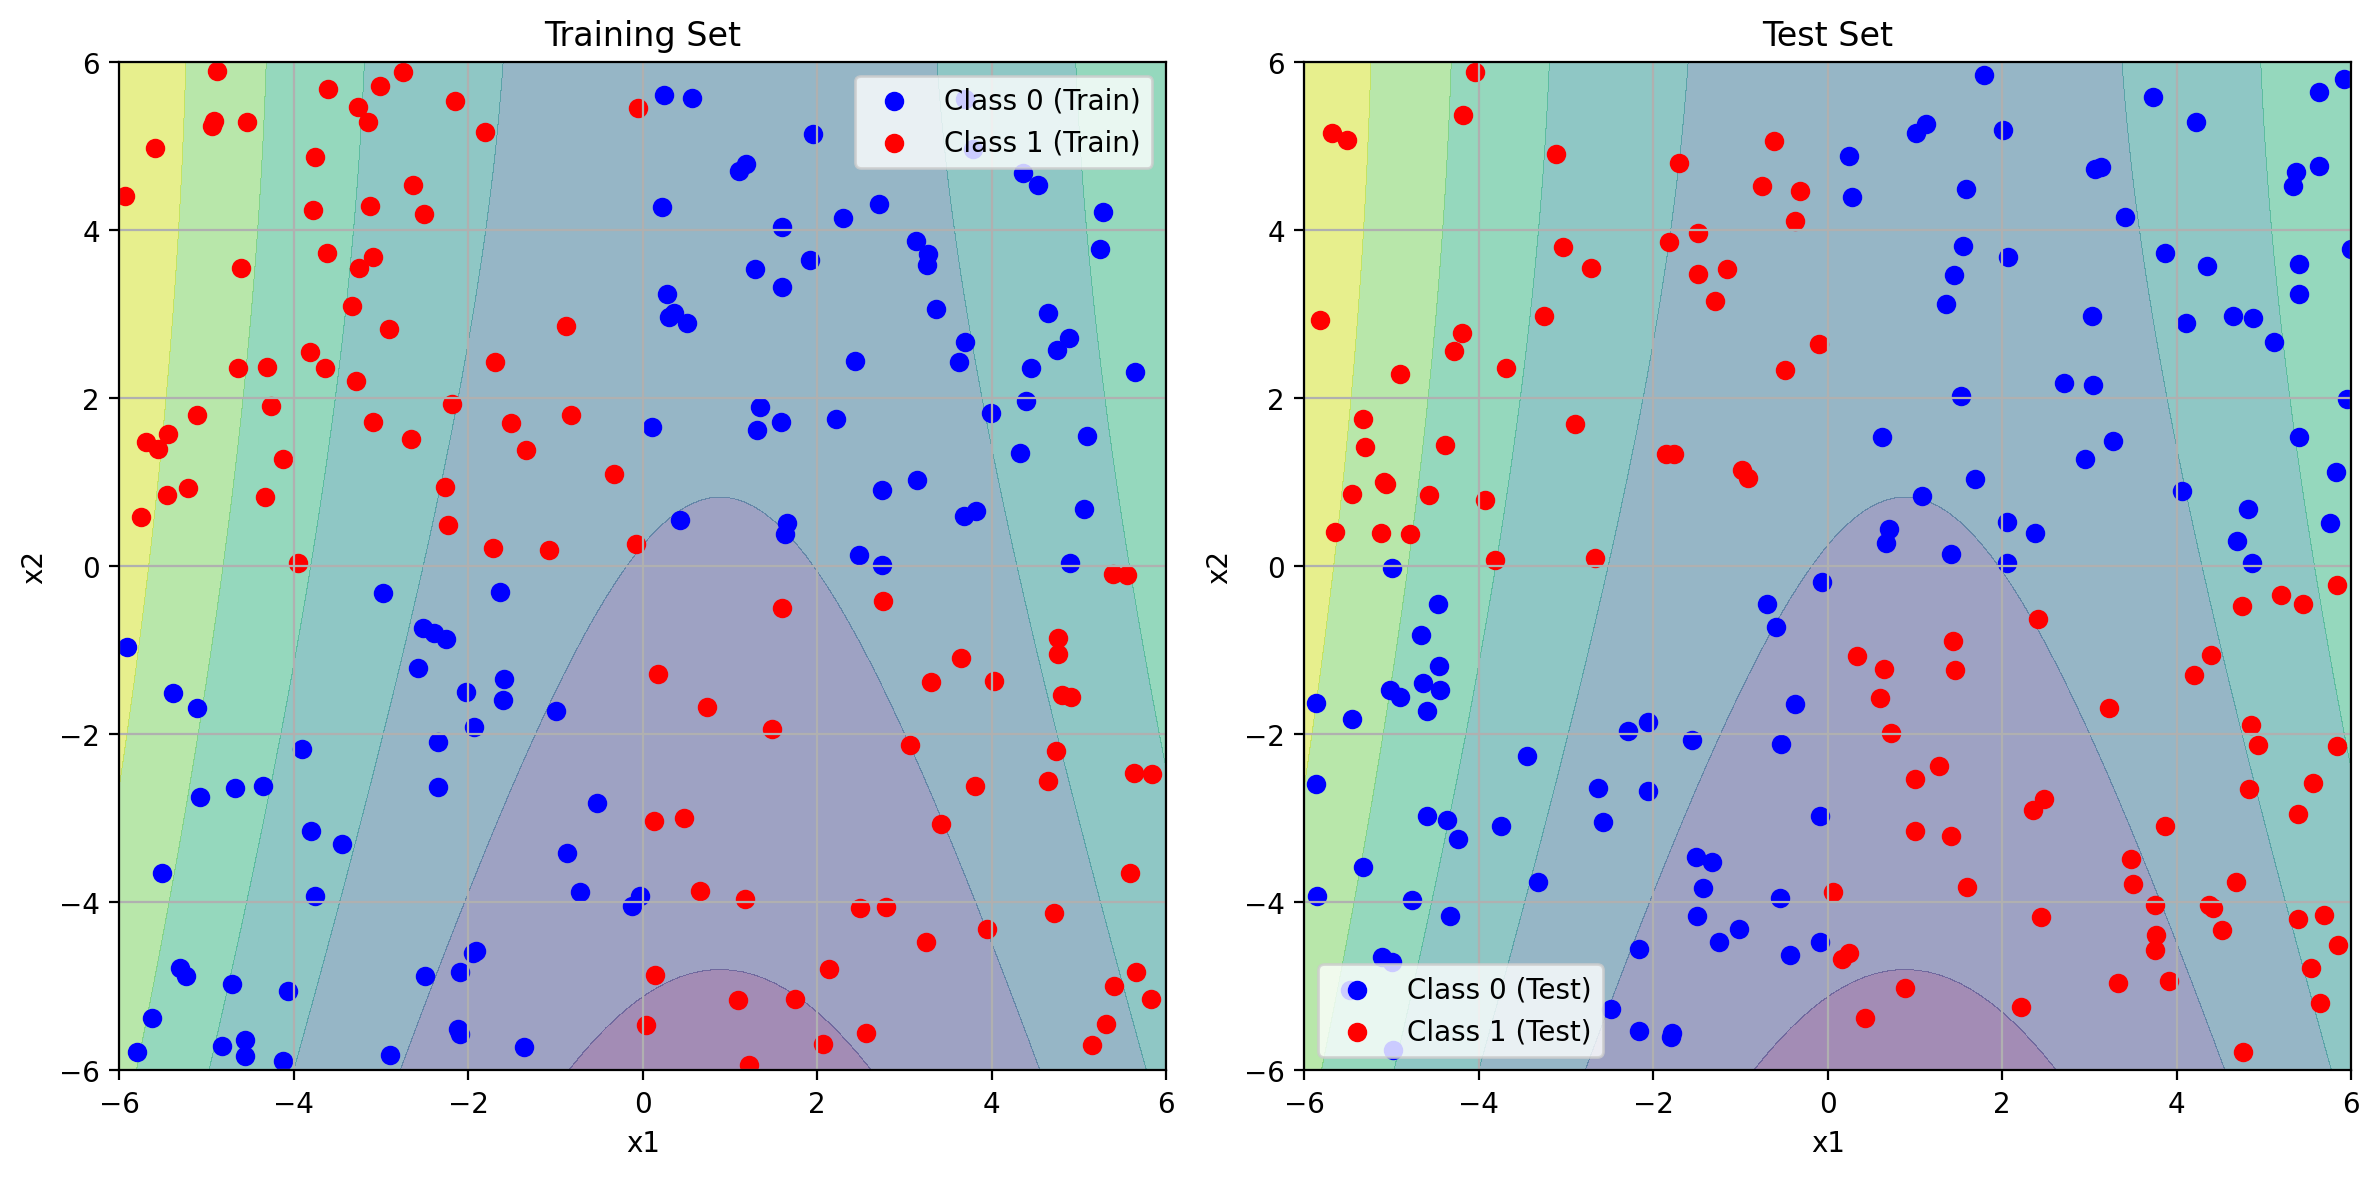

In [99]:
plot_decision_surface(model2, concatenated_x_train, y_train, concatenated_x_test, y_test, s=100)

In [100]:
x_only_with_squares = x_with_squares[:, 2:]
model3 = LogisticRegression(2)
opt2 = torch.optim.Adam(model3.parameters(), lr=0.01)

converged = False
prev_loss = 1e8 
i = 0
while not converged:
    opt2.zero_grad()
    logits = model3(torch.tensor(x_only_with_squares, dtype=torch.float32))
    loss = nn.BCEWithLogitsLoss()(logits, targets_train)
    loss.backward()
    opt2.step()
    if i%10==0:
        print(i, loss.item())
    if np.abs(prev_loss - loss.item()) < 1e-5:
        converged = True
    prev_loss = loss.item() 
    i = i + 1

0 3.09212589263916
10 2.0947299003601074
20 1.5047578811645508
30 1.2120546102523804
40 0.9801986813545227
50 0.775808572769165
60 0.7190661430358887
70 0.7182648181915283
80 0.7139207720756531
90 0.7077445387840271
100 0.7051386833190918
110 0.7029768228530884
120 0.70079505443573
130 0.6989423632621765
140 0.6972634792327881
150 0.6957420110702515
160 0.694386899471283
170 0.693179726600647
180 0.6921120285987854
190 0.6911737322807312
200 0.6903536319732666
210 0.6896410584449768
220 0.6890251636505127
230 0.6884959936141968
240 0.6880435943603516
250 0.6876589059829712
260 0.687333345413208
270 0.6870593428611755
280 0.6868298053741455
290 0.686638593673706
300 0.6864800453186035
310 0.6863490343093872


In [101]:
x11 = concatenated_x_test[:, 0]
x12 = concatenated_x_test[:, 1]

x11_sq = x11 ** 2
x12_sq = x12 ** 2
x_test_only_with_squares = np.column_stack((x11_sq, x12_sq))

prediction_train = model3(torch.tensor(x_only_with_squares, dtype=torch.float32))
prediction_test = model3(torch.tensor(x_test_only_with_squares, dtype=torch.float32))
probs_train = torch.sigmoid(prediction_train)
probs_test = torch.sigmoid(prediction_test)
y_pred_train = (probs_train > 0.5).float()
y_pred_test = (probs_test > 0.5).float()
train_accuracy = (y_pred_train == targets_train).sum().item() / len(targets_test)
test_accuracy = (y_pred_test == targets_test).sum().item() / len(targets_test)
print(f'Train accuracy: {train_accuracy:.2f}, Test accuracy: {test_accuracy:.2f}')

Train accuracy: 0.53, Test accuracy: 0.53


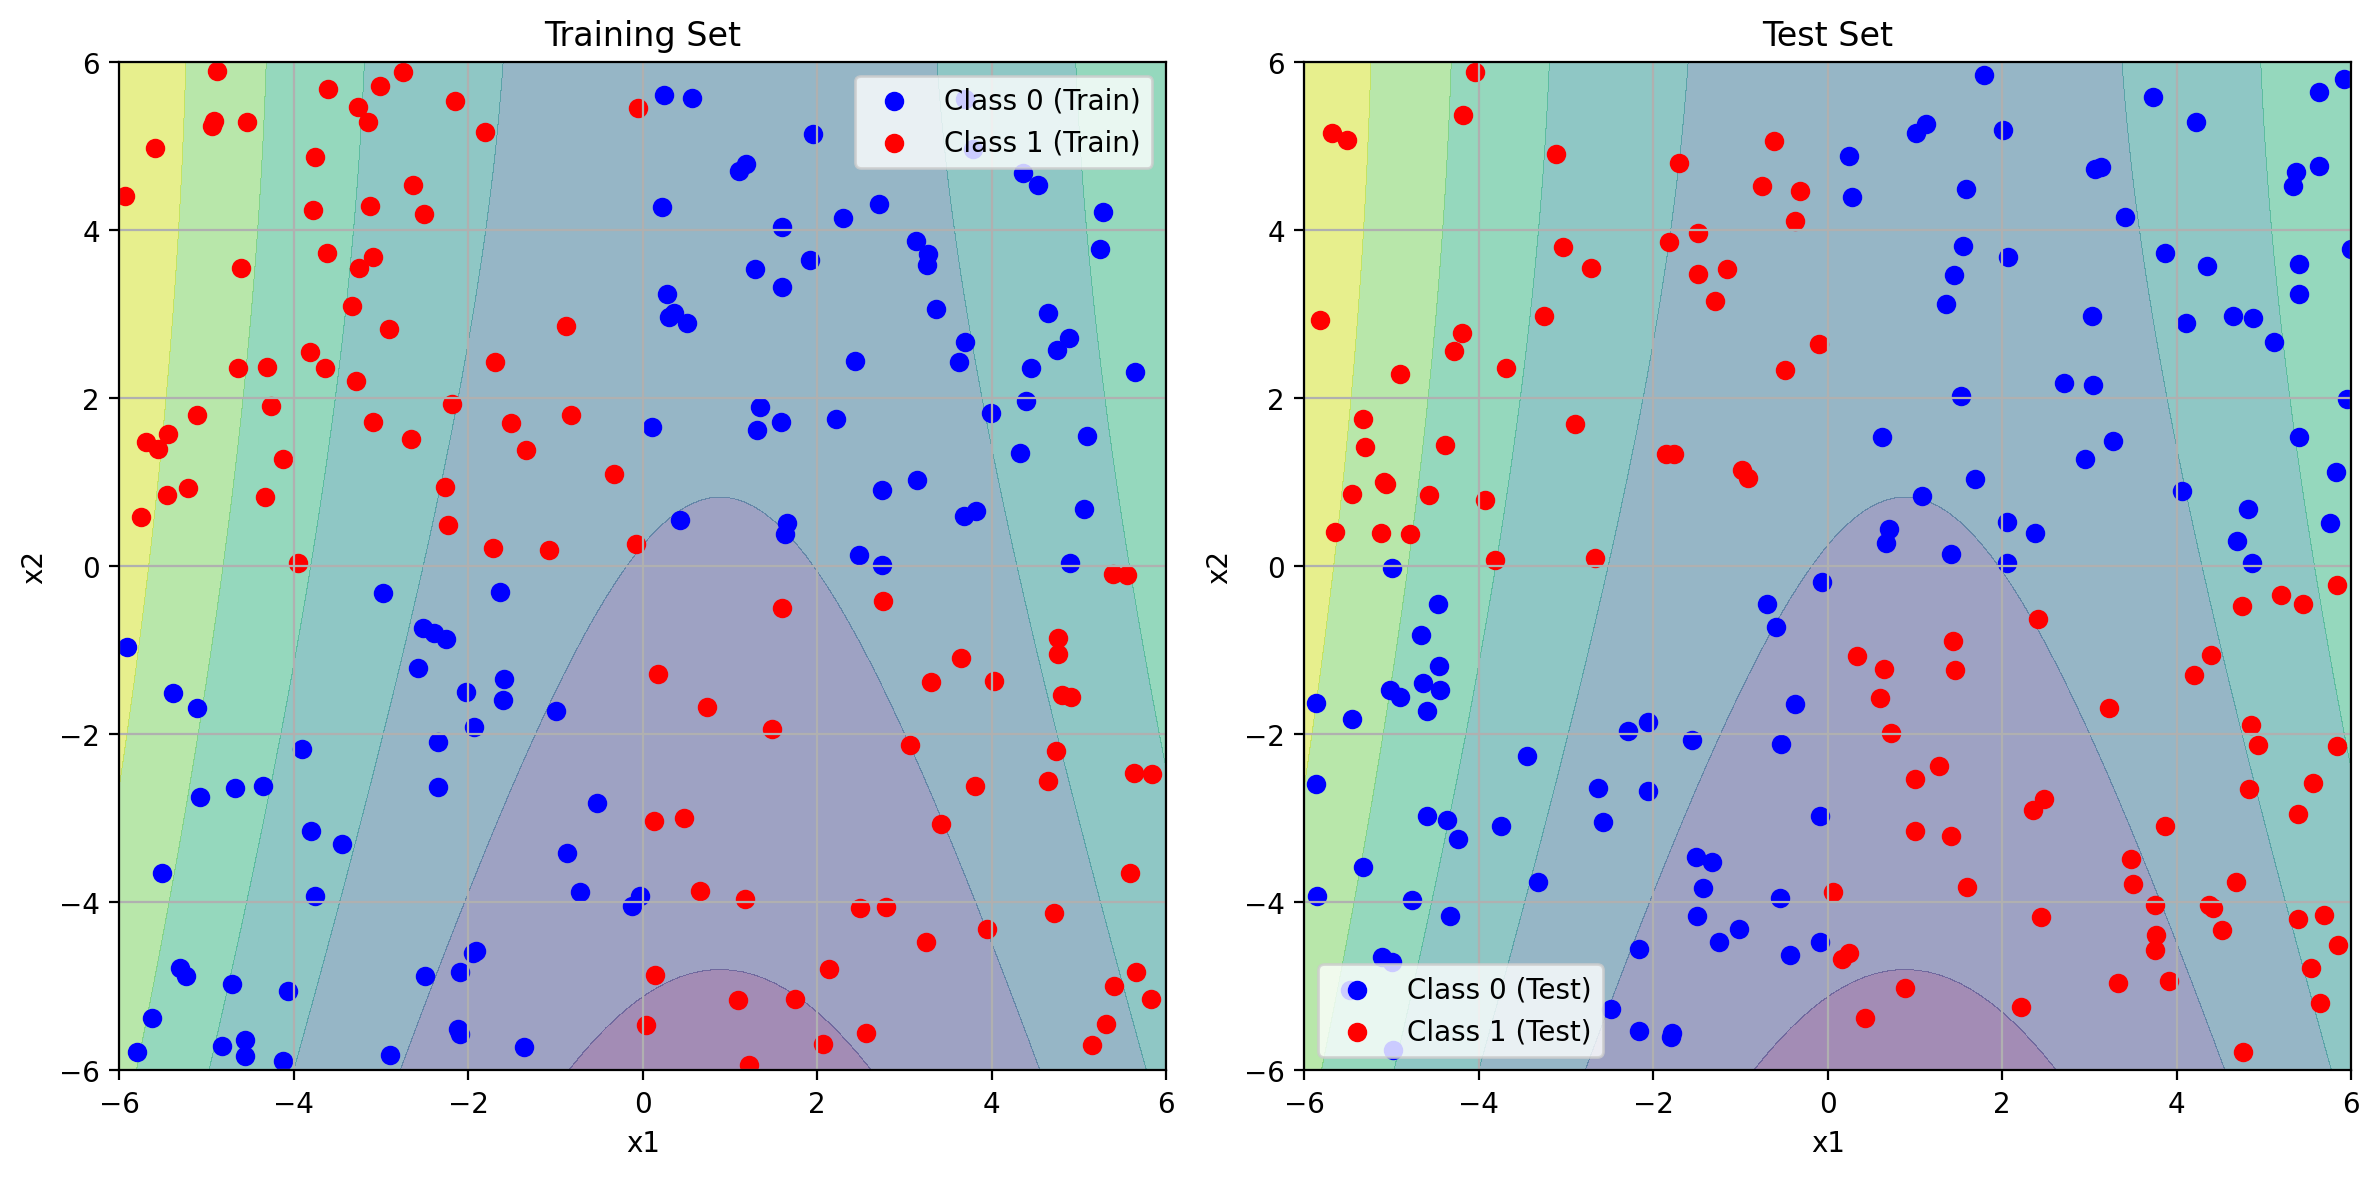

In [102]:
plot_decision_surface(model3, concatenated_x_train, y_train, concatenated_x_test, y_test, s=100)